# <span style="color:green">Early Detection of Crop Stress From Thermal Infrared Imagery</span>
Erik Anderson &
Tyler Cruickshank

![Hydrosat](https://uploads-ssl.webflow.com/61e4aee27ac4a95d23ab9609/61e9d6f5d6578e8c7c0cca8f_solutions-thermal-min.jpg)

# <span style="color:green">Project Oerview</span>

<font size="4">Modern agribusiness employs targeted technology to optimize cropland productivity using modern information and communication technologies at fine spatial resolution (within-field scale). High resolution remotely sensed data of soil conditions and vegetation health provides near real-time information that informs adaptive irrigation and fertilization technology. NDVI is a commonly used remotely sensed index that provides data on the "greenness" or health of crop vegetation. However, the NDVI index is a lagging indicator of crop stress because water or heat stress occurs prior to the degradation of vegetation greenness.

This project aims to support this effort by exploring the relationship between land surface temperature and canopy temperature, an index known as Canopy Air Temperature Index (CATD), to evaluate the availability of moisture to the crops. When crop moisture is limited, leaf stomata close which prevents cooling of the leaf surface and leads to a larger values of CATD.</font>

## <span style="color:green">Project Location</span>

<font size="4">The project is focused on agricultural areas with active farming.  At present, we are extracting data for locations in the San Joaquin Valley, CA and near Ames, Iowa.  In this notebook, we are focused on developing a process for extracting and evaluating time-series data from a point location.  Future notebook iterations may include a spatial analysis that incorporates processes developed from our time-series work.</font>

# <span style="color:green">Data Overview</span></span>

<font size="4">Hydrosat provides a proprietary "fused" thermal infrared land surface temperature (LST) imagery product that is downscaled to 20 m resolution using a combination of MODIS, Sentinel and Landsat imaging platforms.  Hydrosat utilizes a data mining approach for sharpening thermal satellite imagery (DMS) (Gao, F. 2012) and a separate algorithm for interpolating land surface temperature between measurement points (STARFM) (Gao, F 2006). This high resolution fused product is produced daily and presents an added value opportunity for agribusiness.  The same process produces a paired downscaled 20m NDVI fused product.

The data is accessed from a Spatial Temporal Asset Catalog (STAC).  STAC is a specification standard with a unified language to describe geospatial data which allows it to be more easily searchable and queryable. </font>

# <span style="color:green">Notebook Code Overview</span>

<font size="4">At present, this notebook is designed to perform an analysis for a time-series of single specified point.

The backbone of this notebook utilizes the Hydrosat Fusion Hub class.  The class has methods for:
1. Logging in to the STAC.
2. Querying the STAC for specified imagery.
3. Creating a FH Hydrosat object which provides purposeful utility.
4. Extracting time-series for a point location.

We have written additional code to:
1. Extract time-series of individual components of the fused LST data products.
2. Plot the individual components to reveal variations in each component.
3. Extract meteorological data for the time-frame using the HRRR API.
4. Compute a Canopy Air Temperature Difference (CATD) time-series product using LST and air temperature
5. Extract and compute time-series of NDVI components of the fused NDVI data product.
5. Plot the individual NDVI components.
</font>

## <span style="color:green">References</span>

Gao, F. Masek, J. Schwaller, M. Hall, F. 2006. On the Blending of Landsat and MODIS Surface Reflectance: Predicting Landsat Surface Reflectance. IEE Transaction on Geoscience and Remote Sensing Vol 44, No 8.

Gao, F. Kustas, W. Anderson, M. 2012. A Data Mining Approach for Sharpening Thermal Satellite Imagery Over Land. Remote Sensing. doi: 10.3390/rs4113287.

Karnieli, A., Agam, N., Pinker, R., Anderseon, M., Imhoff, M., Gutman, G., Panov, N., Goldberg, A., Use of NDVI and Land Surface Temperature for Drought Assessment: Merits and Limitations.  Journal of Climate. Vol 23. 2010

Y. Erdem , T. Erdem , A.H. Orta & H. Okursoy. Canopy-air temperature differential for potato under different irrigation regimes. Acta Agriculturae Scandinavica Section B-Soil and Plant Science, 2006; 56: 206216


## <span style="color:green">Collaborators </span>

- [Erik Anderson](https://github.com/eriktuck)
- [Tyler Cruickshank](https://github.com/tcruicks)
- [Joe McGlinchy](https://github.com/joemcglinchy)
We thank Joe McGlinchy of Hydrosat for providing project guidance and data access.

In [191]:
import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio

from botocore.exceptions import ClientError
from datetime import date
from datetime import datetime
from distutils.command import sdist
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie

os.environ['USE_PYGEOS'] = '0'


### FUNCTIONS.  No user editing is required.

In [192]:
# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """

    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 500
    )

    #items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("colllection: {} \n".format(collection))
    print ("Number of fusion tiles available: {}".format(num_tiles))

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def extract_time_series(items, bbox, tol, var_name, asset, band):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
 
    # Create a range of dates
    DATES = pd.date_range(
        start=start,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

# ---------------------------------------------------------------------------------


### Login to STAC.

In [193]:
# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### Set up analysis.  User edits required in cell below.

In [194]:
# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

# Location for time-series data extraction.
lat = 42.0   
lon = -93.7  

bbox = [-93.68802, 42.00908, -93.68783, 41.991]  

# Specify dates & hour for LST analysis.
start = "2020-04-01"  
end = "2020-09-30"  
hr_s = "00:00:00"  
hr_e = '23:59:59'
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Create dict of coords.
geom = {'type': 'Point', 'coordinates': [lon, lat]} 

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_s_form = "T{}Z".format(hr_s)
hr_e_form = "T{}Z".format(hr_e)
start_date = start + hr_s_form
end_date = end + hr_e_form


### This is the "main" cell where we get all the LST data. Edits not required but possible for extraction parameters.

In [205]:
# LST collections to search.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting
# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------
asset_dict = {
    "starfm_predictions_modis_landsat" : ['starfm_lst', 40, 20, 'red'],
    "pydms_sharpened_landsat" : ['pydms_lsat_lst', 40, 20, 'blue'],
    "pydms_sharpened_modis" : ['pydms_modis_lst', 1000, 500, 'green'],
    "prepped_inputs_mod21a1d" : ['mod21a1d_lst', 2000, 1000, 'brown'],
    "prepped_inputs_landsat" : ['lsat_lst', 60, 30, 'black'],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Create new master dataframe to append to
# starting with our full date range.
days = pd.date_range(start, end) 
master_lst_df = pd.DataFrame({'date': days})
master_lst_df.set_index('date', inplace=True)

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    # Search and retrieve images.
    (found_items, num_tiles) = stac_tile_search(asset, geom, start_date, end_date)
    # Extract data. Note: we pass band=0 as the last argument.
    (lst_time_series_df) = (extract_time_series(
        found_items, bbox, 
        asset_dict[asset][1], asset_dict[asset][0], 
        'lst', 0))

    # Merge each df into master dataframe.
    # Merge on index (date) and keep all rows from both dfs (inner join).
    master_lst_df = pd.merge(
        master_lst_df, lst_time_series_df, 
        left_index=True, right_index=True, how = 'outer')


colllection: starfm_predictions_modis_landsat 

Number of fusion tiles available: 156
using 6 processes to sample 156 assets
colllection: pydms_sharpened_landsat 

Number of fusion tiles available: 23
using 6 processes to sample 23 assets
colllection: pydms_sharpened_modis 

Number of fusion tiles available: 179
using 6 processes to sample 179 assets
colllection: prepped_inputs_mod21a1d 

Number of fusion tiles available: 179
using 6 processes to sample 179 assets
colllection: prepped_inputs_landsat 

Number of fusion tiles available: 23
using 6 processes to sample 23 assets


### Plot up the results of LST from all collections.

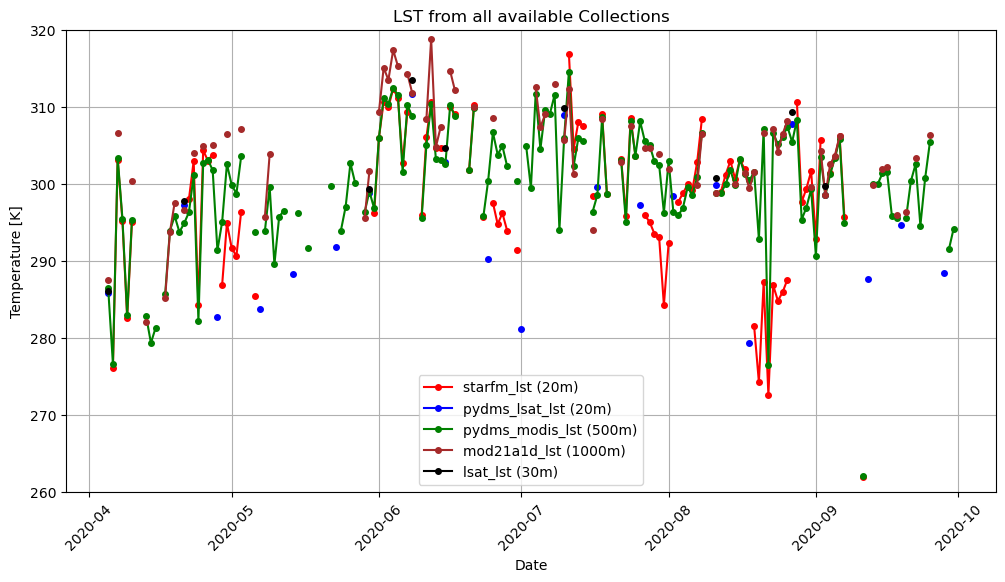

In [206]:
# Now plot LST and 2mT ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    ax = (plt.plot(
        master_lst_df.index, master_lst_df[asset_dict[asset][0]], 
        label="{} ({}m)".format(asset_dict[asset][0], asset_dict[asset][2]),
        marker='o', markersize=4, c=asset_dict[asset][3],)
        )

# This may cut off some outlying points.
plt.ylim(260, 320)

plt.title('LST from all available Collections')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Get HRRR 2-m Temperature data and put it in it's own dataframe.

In [207]:
# Get the hrrr data.
hrrr = get_hrrr_point_data(lat, lon, start, num_days)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
hrrr_df = hrrr.to_dataframe()

# Make date consistent in format.
hrrr_df.reset_index(inplace=True)
hrrr_df['date'] = pd.to_datetime(hrrr_df['time'].dt.date)

# Set the index to date just like the other dataframes.
hrrr_df.set_index('date', inplace=True)

### Plot 2-m air temperature.

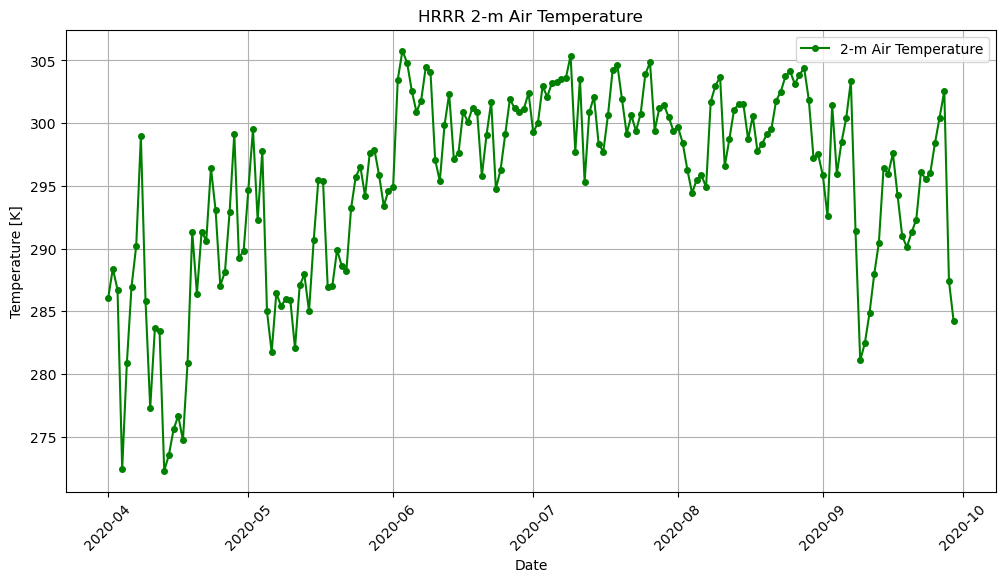

In [216]:
# Now plot HRRR 2-m Temperature  ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

ax = (plt.plot(
    hrrr_df.index, 
    hrrr_df['t2m'], 
    label="2-m Air Temperature",
    marker='o', markersize=4, c='green',
    ))

plt.title('HRRR 2-m Air Temperature')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Now, we'll calculate CATD for each of the assets and create a new dataframe.

In [209]:
# CATD will be calculated as:
#    CATD = asset's LST - HRRR 2m Temperatures

# Create a new dataframe and pre-fill with dates.
days = pd.date_range(start, end) 
catd_df = pd.DataFrame({'date': days})
catd_df.set_index('date', inplace=True)

# Loop through the master_lst_df and calculate CATD for each asset.
# Save in a CATD dataframe.
for i, asset in enumerate(asset_dict):

    catd_col = "catd_{}".format(asset_dict[asset][0])
    catd_df[catd_col] = master_lst_df[asset_dict[asset][0]].sub(hrrr_df['t2m'])


### Plot the CATD for each asset's LST and HRRR 2m temperature.

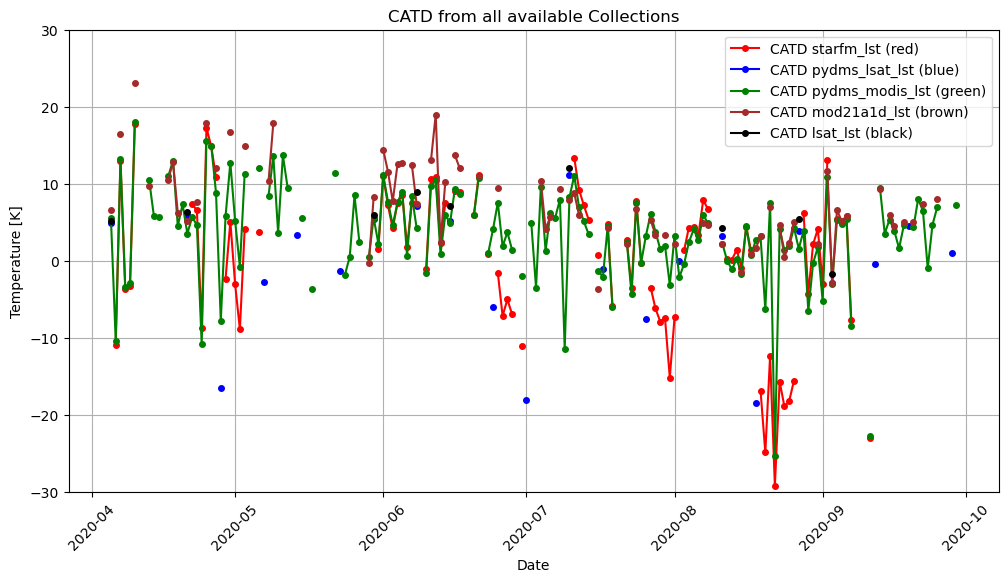

In [210]:
# Now plot CATD  ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    # This the the name of the columns in the catd df.
    # Just makes it shorter for later use.
    col = "catd_{}".format(asset_dict[asset][0])

    ax = (plt.plot(
        catd_df.index, 
        catd_df[col], 
        label="CATD {} ({})".format(asset_dict[asset][0], asset_dict[asset][3]),
        marker='o', markersize=4, c=asset_dict[asset][3]),
        )

# This may cut off some outlying points.
plt.ylim(-30, 30)

plt.title('CATD from all available Collections')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Calculate NDVI
* Surface reflectance is extracted for each collection and NDVI is calculated.

In [211]:
# NDVI collections to search.
# Dictionary keys are: var_name, tolerance, band nir, band red, resolution, plot color.
asset_dict = {
    "prepped_inputs_mcd43a4" : ['mcd43a4_band', 1000, 'b1', 'b0', '500m', 'blue'],
    "prepped_inputs_s2" : ['sentinel2_band', 40, 'b6', 'b2', '20m', 'red'],
    "starfm_predictions_modis_s2" : ['starfm_band', 40, 'b0', 'b0', '20m', 'green'],
}

# Create new master dataframe to append to
# starting with our full date range.
days = pd.date_range(start, end) 
master_ndvi_df = pd.DataFrame({'date': days})
master_ndvi_df.set_index('date', inplace=True)

for i, collection in enumerate(asset_dict):

    # Search and retrieve images.
    (found_items, num_tiles) = stac_tile_search(collection, geom, start_date, end_date)

    # The starfm collection is queried differently than the other collections
    # so we need an if condition to treat the requests differently.
    if collection == ('starfm_predictions_modis_s2'):

        # Extract red
        asset = 'surface_reflectance_red'
        (red_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'red_sr', 
            asset, band=0 ))
        
        # Extract nir
        asset = 'surface_reflectance_nir'
        (nir_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'nir_sr', 
            asset, band=0 ))
        
        # Copute NDVI
        ndvi_df = pd.DataFrame()
        ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) 
                / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
         # Give the ndvi data column an appropriate name.
        var_name = "ndvi_{}".format(asset_dict[collection][0])
        ndvi_df[var_name] = ndvi
       
    else:

        # Extract red band ----------
        asset = 'surface_reflectance'
        red_band = (asset_dict[collection][3])[-1]
        (red_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'red_sr', 
            asset, band=red_band))
        
        # Extract nir band ----------
        asset = 'surface_reflectance'
        nir_band = (asset_dict[collection][2])[-1]
        (nir_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'nir_sr', 
            asset, band=nir_band ))

        # Copute NDVI
        ndvi_df = pd.DataFrame()
        ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) 
                / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
       
        # Give the ndvi data column an appropriate name.
        var_name = "ndvi_{}".format(asset_dict[collection][0])
        ndvi_df[var_name] = ndvi


    # Merge each df into master dataframe.
    # Merge on index (date) and keep all rows from both dfs (inner join).
    master_ndvi_df = pd.merge(
        master_ndvi_df, ndvi_df, 
        left_index=True, right_index=True, how = 'outer')  

colllection: prepped_inputs_mcd43a4 

Number of fusion tiles available: 175
using 6 processes to sample 175 assets
using 6 processes to sample 175 assets
colllection: prepped_inputs_s2 

Number of fusion tiles available: 40
using 6 processes to sample 40 assets
using 6 processes to sample 40 assets
colllection: starfm_predictions_modis_s2 

Number of fusion tiles available: 144
using 6 processes to sample 144 assets
using 6 processes to sample 144 assets


### Plot the NDVI for each asset.

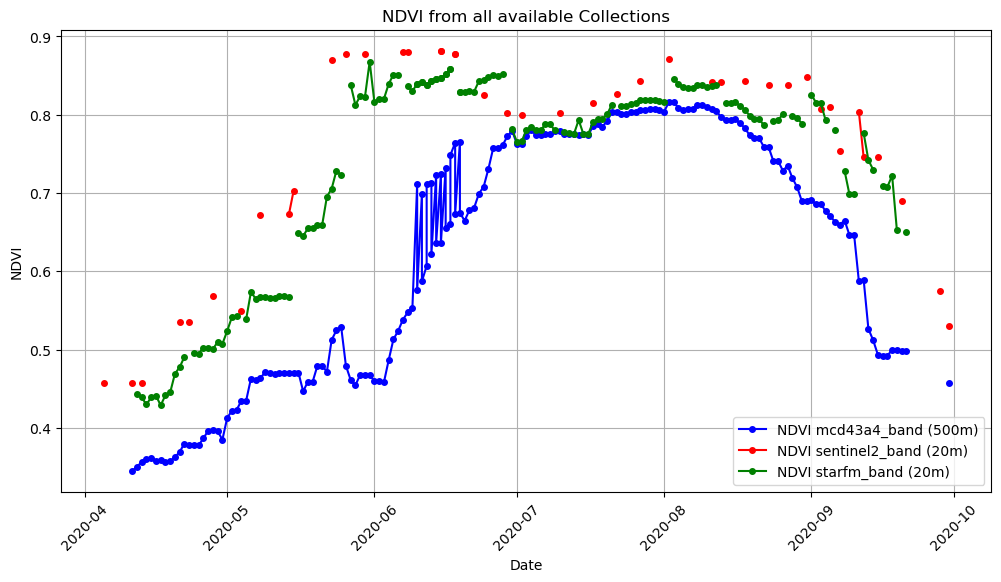

In [212]:
# Now plot NDVI ----------------------
asset_dict = {
    "prepped_inputs_mcd43a4" : ['mcd43a4_band', 1000, 'b1', 'b0', '500m', 'blue'],
    "prepped_inputs_s2" : ['sentinel2_band', 40, 'b6', 'b2', '20m', 'red'],
    "starfm_predictions_modis_s2" : ['starfm_band', 40, 'b0', 'b0', '20m', 'green'],
}

fig, ax = plt.subplots(figsize=(12, 6))

for i, collection in enumerate(asset_dict):

    var_name = "ndvi_{}".format(asset_dict[collection][0])

    ax = (plt.plot(
        master_ndvi_df.index, 
        master_ndvi_df[var_name], 
        label="NDVI {} ({})".format(asset_dict[collection][0], asset_dict[collection][4]),
        marker='o', markersize=4, c=asset_dict[collection][5]),
        )

plt.title('NDVI from all available Collections')
plt.grid(True)
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()